In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
from glob import glob
import numpy as np

Using TensorFlow backend.


In [21]:
def load_dataset(path):
    data = load_files(path)
    filenames = np.array(data['filenames'])
    print(filenames)
    targets = np_utils.to_categorical(np.array(data['target']), 12)
    categories = np.array(data['target_names'])
    return filenames, targets, categories

#load dataset
#train_filenames, y_targets, seedling_categories = load_dataset('seedling_data/train')
#print('Total number of images: ', len(train_filenames)) #4750
#load list of categories
#categories = seedling_categories
#print('List of categories: ', seedling_categories)

test_filenames, no_target, test_categories = load_dataset('seedling_data/test')
print('Total number of images: ', len(test_filenames)) #4750

[]
Total number of images:  0


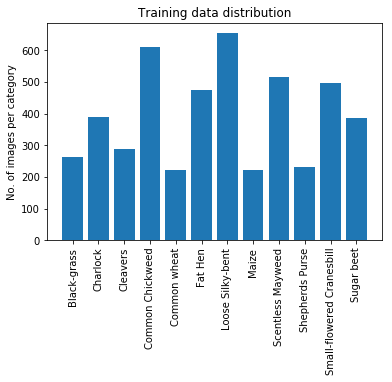

In [17]:
import matplotlib.pyplot as plt
'''
Function for displaying categorical data distribution to check if dataset is balanced
TODO: data augmentation if dataset is unbalanced
'''
category_count = np.sum(y_targets, axis = 0) # count of each class
def categorical_dist_graph(categories, count):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(categories)), count)
    ax.set_ylabel('No. of images per category')
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories, rotation = 'vertical')
    ax.set_title('Training data distribution')
    plt.show()

categorical_dist_graph(categories, category_count)

In [ ]:
import seaborn as sns

category_count = np.sum(y_targets, axis = 0) # count of each class
def categorical_dist_graph(categories, count):
    sns.set(color_codes=True)
    sns.distplot